# Text Classification Using TF-IDF and OpenAI Embeddings 

<u><b>Full Procedure<u><b>

1. Import Dependencies, Load and Prepare the Data
- All necessary libraries are imported, including data handling tools (Pandas, NumPy), visualization (Matplotlib), and machine learning tools from scikit-learn
- The dataset is loaded from a CSV file. The column <code>Embeddings</code> contains stringified lists, which are converted to actual lists using <code>literal_eval</code>
- The Embeddings from OpenAI are already available in the dataset
- The data used for the classification task is composed of the Summary and Description of the bug reports, while the class label is the Priority field

2. Text Vectorization (TF-IDF)
- The text data is vectorized using <code>TfidfVectorizer</code>, converting it into numerical features based on term frequency and inverse document frequency

3. Model Training (Random Forest)
- Next, the dataset is split into training and testing subsets to evaluate model performance
- A <code>RandomForestClassifier</code> is trained on the vectorized text data to learn how to classify the input data
- The model is used separately on to learn the patterns on the text vectorized with OpenAI Embeddings, and with TF-IDF 

4. Evaluation
- Model performance is evaluated using several classification metrics: accuracy, precision, recall, F1-score, ROC-AUC, and precision-recall curve
- The precision-recall curve is plotted to visualize model performance
- The ROC-AUC curve is plotted to account for data imbalance

### Imports and Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
        precision_recall_curve, roc_curve 

In [3]:
data_path = "bug_reports_mozilla_firefox_resolved_fixed_comments_embeddings.csv"

data = pd.read_csv(data_path)
data["Embeddings"] = data.Embeddings.apply(literal_eval).apply(np.array)  # Convert string to array

In [4]:
# The data used for the classification task is composed of the Summary and Description of the bug reports, while the class label is the Priority field
data.head(2)

,Bug ID,Type,Summary,Product,Component,Status,Resolution,Priority,Severity,Description,Concat,N_tokens,Embeddings
0,1955715,enhancement,Update addonsInfo asrouter targeting to allow ...,Firefox,Messaging System,RESOLVED,FIXED,P1,--,"Currently, the addonsInfo targeting returns an...",summary update addonsinfo asrouter target allo...,80,"[-0.015150155872106552, 0.003520532278344035, ..."
1,1953155,task,Enable expand on hover and remove coming soon ...,Firefox,Sidebar,RESOLVED,FIXED,P1,--,"When expand on hover is enabled, the message s...",summary enable expand on hover remove coming s...,55,"[-0.01597077213227749, 0.009659321047365665, 0..."


In [5]:
# The class label (Priority) is unbalanced
data["Priority"].value_counts()

Priority
P1    5534
P2    2999
P3     623
Name: count, dtype: int64

In [6]:
# Drop the P3 class, since we have just a few examples, making it a binary classification problem
data = data[data["Priority"] != "P3"].reset_index(drop = True)

In [7]:
# Class labels after dropping the P3 class
data["Priority"].value_counts()

Priority
P1    5534
P2    2999
Name: count, dtype: int64

### Classifying with TF-IDF

In [8]:
# Vectorize the Concat column, which is composed of a concatenation of the Summary and Description columns
vector = TfidfVectorizer()
tf_idf = vector.fit_transform(data["Concat"])
tf_idf_data = pd.DataFrame(tf_idf.todense(), columns = vector.get_feature_names_out())

In [9]:
# The data vectorized with TF-IDF has a dimension of 13.273 words
tf_idf_data.shape

(8533, 13273)

In [10]:
# Split data into train and test
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(
    list(tf_idf_data.values), data.Priority, test_size = 0.2, random_state = 12345
)

In [11]:
# Train random forest classifier
clf_tf_idf = RandomForestClassifier(n_estimators = 100)
clf_tf_idf.fit(X_train_tf_idf, y_train_tf_idf)
preds_tf_idf = clf_tf_idf.predict(X_test_tf_idf)
probas_tf_idf = clf_tf_idf.predict_proba(X_test_tf_idf)

report_tf_idf = classification_report(y_test_tf_idf, preds_tf_idf)
print(report_tf_idf)

              precision    recall  f1-score   support

          P1       0.69      0.94      0.80      1106
          P2       0.68      0.22      0.33       601

    accuracy                           0.69      1707
   macro avg       0.68      0.58      0.56      1707
weighted avg       0.69      0.69      0.63      1707



In [12]:
# Compute overall metrics for the classifier trained with TF-IDF Vectors
acc_tf_idf = accuracy_score(y_test_tf_idf, preds_tf_idf)
prec_tf_idf = precision_score(y_test_tf_idf, preds_tf_idf, pos_label = "P1")
rec_tf_idf = recall_score(y_test_tf_idf, preds_tf_idf, pos_label = "P1")
f1_tf_idf = f1_score(y_test_tf_idf, preds_tf_idf, pos_label = "P1")
roc_auc_tf_idf = roc_auc_score(y_test_tf_idf, probas_tf_idf[:, 1])

### Classifying with Embeddings

In [14]:
# Split data into train and test 
X_train, X_test, y_train, y_test = train_test_split(
    list(data.Embeddings.values), data.Priority, test_size = 0.2, random_state = 12345
)

In [23]:
# The Embeddings from OpenAI have a dimension of 1536
data.Embeddings[0].shape

(1536,)

In [15]:
# Train random forest classifier
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

          P1       0.66      0.97      0.79      1106
          P2       0.65      0.10      0.17       601

    accuracy                           0.66      1707
   macro avg       0.66      0.53      0.48      1707
weighted avg       0.66      0.66      0.57      1707



In [16]:
# Compute overall metrics for the classifier trained with OpenAI Embeddings
acc_emb = accuracy_score(y_test, preds)
prec_emb = precision_score(y_test, preds, pos_label = "P1")
rec_emb = recall_score(y_test, preds, pos_label = "P1")
f1_emb = f1_score(y_test, preds, pos_label = "P1")
roc_auc_emb = roc_auc_score(y_test, probas[:, 1])

### Compare

In [17]:
# Metrics in general
pd.DataFrame({"TF-IDF": [acc_tf_idf, prec_tf_idf, rec_tf_idf, f1_tf_idf, roc_auc_tf_idf], \
              "Embeddings": [acc_emb, prec_emb, rec_emb, f1_emb, roc_auc_emb]}, \
             index = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"])

,TF-IDF,Embeddings
Accuracy,0.688342,0.663738
Precision,0.689314,0.664400
Recall,0.944846,0.971971
F1-Score,0.797101,0.789280
ROC AUC,0.680894,0.651372


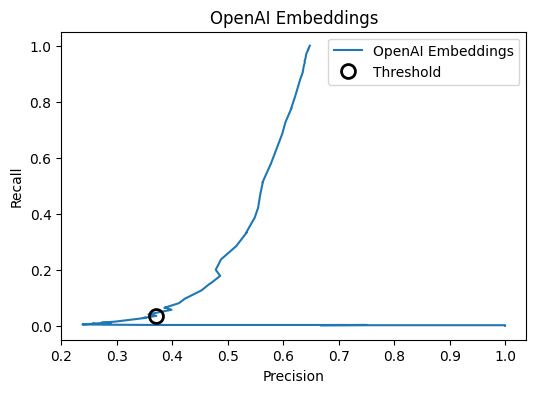

In [29]:
# Plot Precision-Recall Curve for the Open AI Embeddings
plt.rcParams["figure.figsize"] = (6, 4)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label = "P1")
plt.plot(precision, recall, label = "OpenAI Embeddings")
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], 'o', markersize = 10, label = 'Threshold', fillstyle = 'none', c = 'k', mew = 2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("OpenAI Embeddings")
plt.legend(loc = "best")

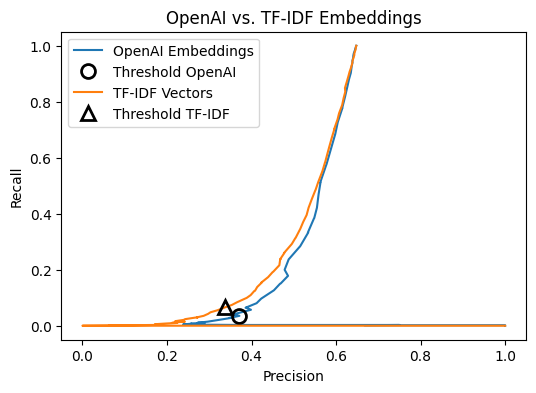

In [28]:
# Compare the Precision-Recall Curve for the OpenAI Embeddings vs. TF-IDF Embeddings
precision_tf_idf, recall_tf_idf, thresholds_tf_idf = precision_recall_curve(y_test_tf_idf, clf_tf_idf.predict_proba(X_test_tf_idf)[:, 1], pos_label = "P1")

plt.plot(precision, recall, label = "OpenAI Embeddings")
plt.plot(precision[close_default], recall[close_default], 'o', markersize = 10, label = "Threshold OpenAI", fillstyle = "none", c = 'k', mew = 2)

plt.plot(precision_tf_idf, recall_tf_idf, label = "TF-IDF Vectors")
close_default_tf_idf = np.argmin(np.abs(thresholds_tf_idf - 0.5))
plt.plot(precision_tf_idf[close_default_tf_idf], recall_tf_idf[close_default_tf_idf], '^', c = 'k', markersize = 10, label = "Threshold TF-IDF", fillstyle = "none", mew = 2)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("OpenAI vs. TF-IDF Embeddings")
plt.legend(loc = "best")

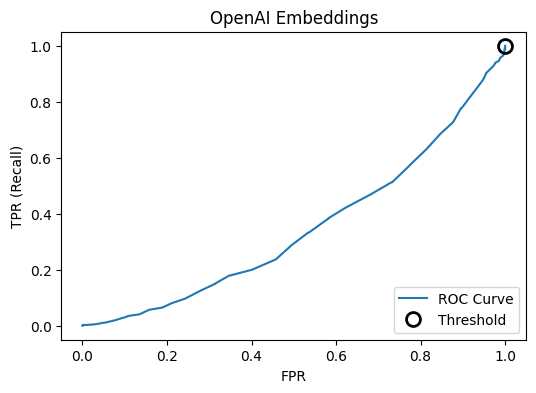

In [33]:
# Plot ROC AUC Curve for the Open AI Embeddings
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label = "P1")
plt.plot(fpr, tpr, label = "ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
# Find Threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize = 10, label = "Threshold", fillstyle = "none", c = 'k', mew = 2)
plt.title("OpenAI Embeddings")
plt.legend(loc = 4)

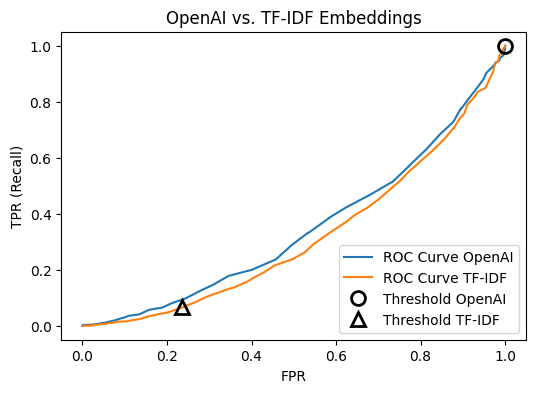

In [37]:
# Compare the ROC AUC Curve for the OpenAI Embeddings vs. TF-IDF Embeddings
fpr_tf_idf, tpr_tf_idf, thresholds_tf_idf = roc_curve(y_test_tf_idf, clf_tf_idf.predict_proba(X_test_tf_idf)[:, 1], pos_label = "P1")

plt.plot(fpr, tpr, label = "ROC Curve OpenAI")
plt.plot(fpr_tf_idf, tpr_tf_idf, label = "ROC Curve TF-IDF")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label = "Threshold OpenAI", fillstyle = "none", c = 'k', mew = 2)

close_default_tf_idf = np.argmin(np.abs(thresholds_tf_idf - 0.5))
plt.plot(fpr_tf_idf[close_default_tf_idf], tpr_tf_idf[close_default_tf_idf], '^', markersize = 10, label = "Threshold TF-IDF", fillstyle = "none", c = 'k', mew = 2)
plt.title("OpenAI vs. TF-IDF Embeddings")
plt.legend(loc = 4)